## Stream video data to the NN

In [26]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import rospy
import time
import os
import PIL
import matplotlib.pyplot as plt
from scipy import misc
import tensorflow as tf
import numpy as np
from deep_car.model import get_model
from deep_car.data import get_steering_delta, get_steering_hist
from PIL import ImageDraw, ImageFont, ImageFilter
#from sensor_msgs.msg import CompressedImage
#from std_msgs.msg import String,Int16


check = 1
s_hist = np.array([[0,0,0,0]])
s_hist.shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(1, 4)

## Init NN

In [22]:
gpu_options = tf.GPUOptions(allow_growth=True) 
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))


len_steering_hist = 4 #get_steering_hist(batch).shape[-1]
len_steering_delta = 6 #get_steering_delta(batch).shape[-1]
y_delta_buckets = 9
input_size = (64,48)
crop_size = input_size
x = tf.placeholder(tf.float32, shape=[None, crop_size[1], crop_size[0], 1], name='image')
steering_hist = tf.placeholder(tf.float32, shape=[None, len_steering_hist], name='steering_hist')

y_abs_true, y_delta_true, opt_op, \
    y_abs_discr_prob, y_abs_loss, y_delta_prob, y_delta_loss = \
        get_model(x, steering_hist, len_steering_delta, y_delta_buckets)
        
        
saver = tf.train.import_meta_graph('../data/model/steering_mixture_prob_exp.ckpt.meta')
saver.restore(sess, tf.train.latest_checkpoint('../data/model/'))

INFO:tensorflow:Restoring parameters from ../data/model/steering_mixture_prob_exp.ckpt


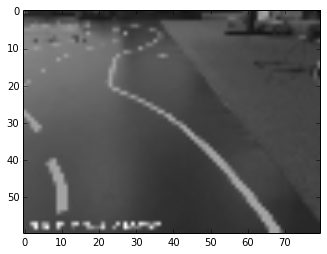

<type 'instance'>
(64, 48)
<PIL.Image._ImageCrop image mode=LA size=64x48 at 0x7F1C0E0770E0>
(3072, 2)


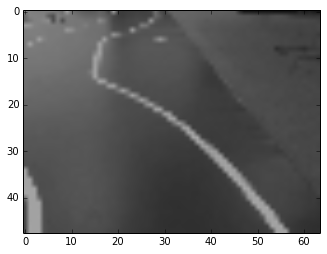

In [57]:
def callbackNN(img):
    X = crop(img)
    y_abs, y_delta = sess.run(
        [ y_abs_discr_prob, y_delta_prob], 
        feed_dict={
            x:X, 
            steering_hist: s_hist
        }
    )
       
#rospy.init_node('PixelDriveNN')

#Crop the middle
def crop(img):
    crop_size = (64, 48)
    resize = (80, 60)
    img = img.convert('LA').resize(resize, resample=PIL.Image.BILINEAR)
    plt.imshow(img)
    plt.show()
    img = img.crop(
        map(
            int,
            [ 0.5 * (resize[0] - crop_size[0]), 
              0.5 * (resize[1] - crop_size[1]),
              0.5 * (resize[0] + crop_size[0]),
              0.5 * (resize[1] + crop_size[1])])
    )
    img.load()
    return img

f = PIL.Image.open("../tmp/tmpyDPJt4/000451.png")
img = np.array(f)
image = crop(f)
print type(image)
print image.size
print np.asarray(image)
print np.array(image.getdata()).shape 
plt.imshow(image)
#callbackNN(f)

In [ ]:
sub = rospy.topics.Subscriber("/app/camera/rgb/image_raw/compressed", CompressedImage, callbackNN)

In [ ]:
pub_steering = rospy.Publisher("/manual_control/steering", Int16, queue_size=10)
pub_speed = rospy.Publisher("/manual_control/speed", Int16, queue_size=10)

In [ ]:
pub_steering.publish(0)
time.sleep(0.5)
for i in range(90):
    time.sleep(0.1)
    pub_steering.publish(i)

In [ ]:
pub_speed.publish(0)